In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from PIL import Image
import random

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# import os

# if os.path.exists("archive.zip"):
#     print("Found archive.zip. Extracting...")
#     with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
#         zip_ref.extractall(".")
#     print("Extraction complete!")
# else:
#     print("archive.zip not found. Please upload the dataset as 'archive.zip'")
#     print("To upload, click on the files icon in the left sidebar, then click on the upload button.")
#     print("After uploading, re-run this cell.")

In [4]:
import kagglehub

path = kagglehub.dataset_download("atulanandjha/lfwpeople")

print("Path to dataset files:", path)

import os
import tarfile

if os.path.exists(path+"/lfw-funneled.tgz"):
    print("Found lfw-funneled.tgz. Extracting...")
    with tarfile.open(path+"/lfw-funneled.tgz", 'r:gz') as tar_ref:
        tar_ref.extractall(".")
    print("Extraction complete!")
else:
    print("lfw-funneled.tgz not found. Please upload the dataset as 'lfw-funneled.tgz'")
    print("To upload, click on the files icon in the left sidebar, then click on the upload button.")
    print("After uploading, re-run this cell.")

Path to dataset files: /kaggle/input/lfwpeople
Found lfw-funneled.tgz. Extracting...
Extraction complete!


In [5]:
def create_dataframe(data_dir):
    image_paths = []
    labels = []

    # Print first few directories to understand the structure
    print(f"Checking dataset structure in: {data_dir}")
    all_items = os.listdir(data_dir)
    print(f"Found {len(all_items)} items")
    if len(all_items) > 0:
        sample_items = all_items[:5]
        print(f"Sample items: {sample_items}")

        # Check if the first item is a directory
        first_item_path = os.path.join(data_dir, all_items[0])
        if os.path.isdir(first_item_path):
            print(f"First item is a directory containing: {os.listdir(first_item_path)[:5]}")

    # Process the directory structure
    for person_name in os.listdir(data_dir):
        person_dir = os.path.join(data_dir, person_name)
        if os.path.isdir(person_dir):
            for image_name in os.listdir(person_dir):
                if image_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(person_dir, image_name)
                    image_paths.append(image_path)
                    labels.append(person_name)

    df = pd.DataFrame({'image_path': image_paths, 'person': labels})
    return df

# Assuming your dataset is extracted to a folder named 'lfw-deepfunneled'
data_dir = '/kaggle/working/lfw_funneled'
df = create_dataframe(data_dir)
print(f"Dataset size: {len(df)}")
print(f"Number of unique people: {df['person'].nunique()}")

# Display a sample of the dataframe
print("\nSample data:")
print(df.head())

Checking dataset structure in: /kaggle/working/lfw_funneled
Found 5760 items
Sample items: ['Michelle_Collins', 'Francois_Pienaar', 'Christopher_Russell', 'Pierce_Brosnan', 'Hugh_Jessiman']
First item is a directory containing: ['Michelle_Collins_0002.jpg', 'Michelle_Collins_0001.jpg']
Dataset size: 13233
Number of unique people: 5749

Sample data:
                                          image_path               person
0  /kaggle/working/lfw_funneled/Michelle_Collins/...     Michelle_Collins
1  /kaggle/working/lfw_funneled/Michelle_Collins/...     Michelle_Collins
2  /kaggle/working/lfw_funneled/Francois_Pienaar/...     Francois_Pienaar
3  /kaggle/working/lfw_funneled/Christopher_Russe...  Christopher_Russell
4  /kaggle/working/lfw_funneled/Pierce_Brosnan/Pi...       Pierce_Brosnan


In [6]:
# Keep only people with at least 10 images (for better training)
counts = df['person'].value_counts()
people_to_keep = counts[counts >= 10].index
df_filtered = df[df['person'].isin(people_to_keep)]
print(f"\nFiltered dataset size: {len(df_filtered)}")
print(f"Number of people after filtering: {df_filtered['person'].nunique()}")

# Create numerical labels
person_to_label = {person: idx for idx, person in enumerate(df_filtered['person'].unique())}
df_filtered['label'] = df_filtered['person'].map(person_to_label)



Filtered dataset size: 4324
Number of people after filtering: 158


/tmp/ipykernel_19/3710122100.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['person'].map(person_to_label)


In [7]:
# Split into train and test sets
train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42,
    stratify=df_filtered['label']
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 3459
Test set size: 865


In [8]:
# Create a custom dataset class
class LFWDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LFWDataset(train_df, transform=train_transform)
test_dataset = LFWDataset(test_df, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
# Visualize some training images
def show_batch(dataloader, n=8):
    # Get a batch of training data
    images, labels = next(iter(dataloader))

    # Convert labels to people names
    label_to_person = {v: k for k, v in person_to_label.items()}
    people = [label_to_person[label.item()] for label in labels]

    # Create a grid of images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(min(n, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(people[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Uncomment to visualize a batch
# show_batch(train_loader)

In [11]:
# Load pre-trained ViT model
class FaceRecognitionViT(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionViT, self).__init__()
        # Load pre-trained ViT model
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        # Replace the classifier head
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Create the model
num_classes = df_filtered['label'].nunique()
model = FaceRecognitionViT(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training function
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images, labels

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images, labels

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 214MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Training loop
num_epochs = 5
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)

    # Evaluate
    val_loss, val_acc, preds, true_labels = evaluate_model(model, test_loader, criterion)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_lfw_model.pth')
        print("Saved best model!")


Epoch 1/5


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 3.4974, Train Acc: 0.3093
Val Loss: 2.2165, Val Acc: 0.5283
Saved best model!

Epoch 2/5


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 1.4110, Train Acc: 0.7450
Val Loss: 1.0199, Val Acc: 0.8358
Saved best model!

Epoch 3/5


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.5115, Train Acc: 0.9491
Val Loss: 0.5614, Val Acc: 0.9225
Saved best model!

Epoch 4/5


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1570, Train Acc: 0.9942
Val Loss: 0.3777, Val Acc: 0.9422
Saved best model!

Epoch 5/5


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0520, Train Acc: 0.9997
Val Loss: 0.2759, Val Acc: 0.9572
Saved best model!


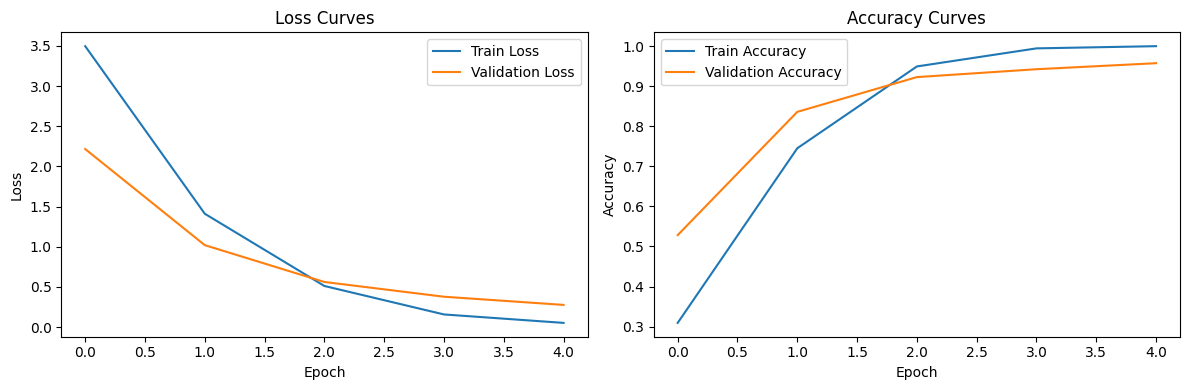

In [13]:
# Visualization of training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

In [14]:
# Final evaluation
model.load_state_dict(torch.load('best_vit_lfw_model.pth'))
val_loss, val_acc, preds, true_labels = evaluate_model(model, test_loader, criterion)
print(f"\nFinal Test Accuracy: {val_acc:.4f}")

# Classification report
label_to_person = {v: k for k, v in person_to_label.items()}
target_names = [label_to_person[i] for i in range(num_classes)]
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=target_names))

/tmp/ipykernel_19/3088784152.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_lfw_model.pth'))


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


Final Test Accuracy: 0.9572

Classification Report:
                           precision    recall  f1-score   support

           Pierce_Brosnan       1.00      1.00      1.00         3
           Walter_Mondale       1.00      1.00      1.00         2
         Condoleezza_Rice       0.67      1.00      0.80         2
              Jackie_Chan       1.00      1.00      1.00         3
            Jacques_Rogge       1.00      0.50      0.67         2
             Gordon_Brown       1.00      1.00      1.00         3
              Igor_Ivanov       1.00      0.75      0.86         4
              Vicente_Fox       0.86      1.00      0.92         6
            Nicole_Kidman       0.80      1.00      0.89         4
             Keanu_Reeves       1.00      1.00      1.00         2
              Ann_Veneman       1.00      1.00      1.00         2
              Tom_Daschle       1.00      1.00      1.00         5
          Hillary_Clinton       1.00      1.00      1.00         3
        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


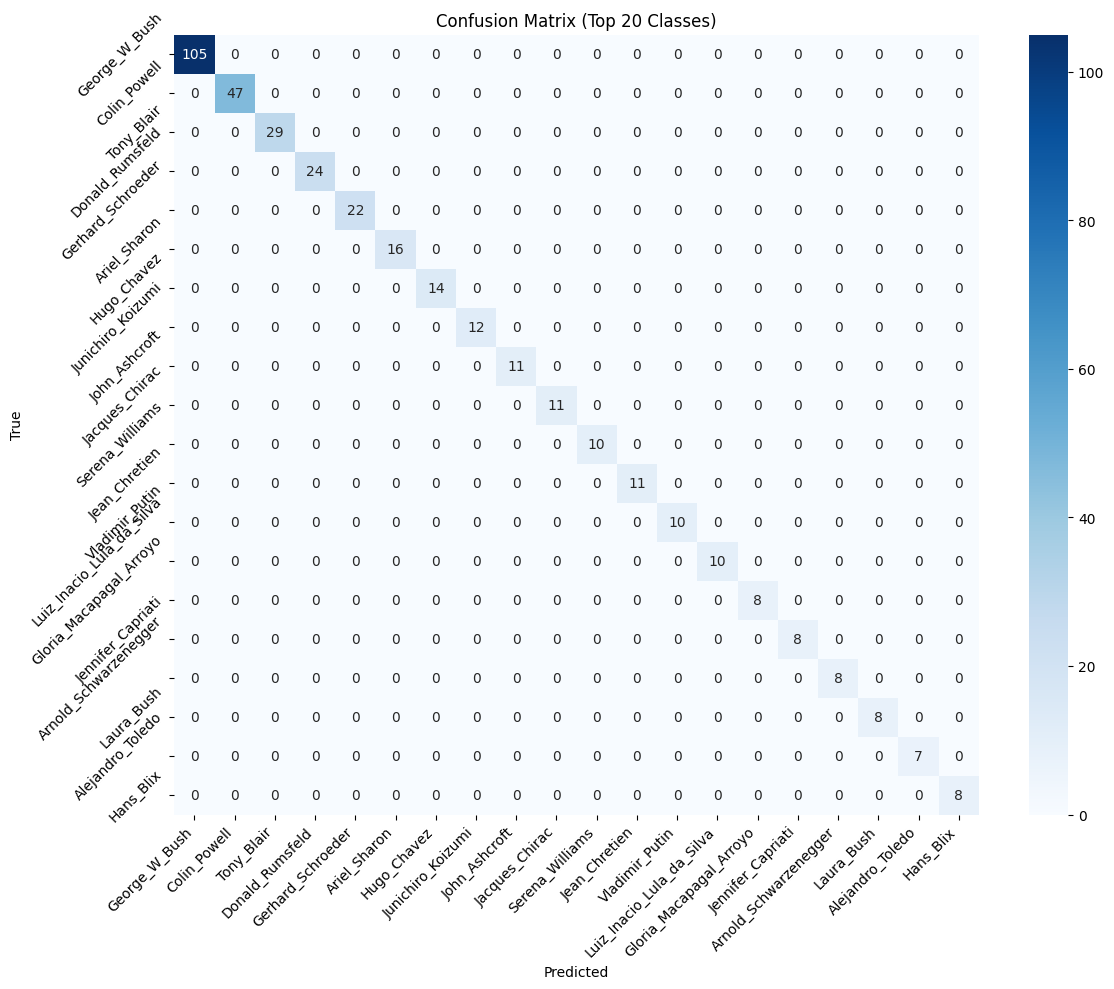

In [15]:
# Confusion matrix (for top classes)
def plot_confusion_matrix(y_true, y_pred, top_n=20):
    # Count occurrences of each class
    unique, counts = np.unique(y_true, return_counts=True)

    # Get the top N most frequent classes
    top_indices = np.argsort(-counts)[:top_n]

    # Filter data to include only top classes
    mask = np.isin(y_true, top_indices)
    y_true_filtered = np.array(y_true)[mask]
    y_pred_filtered = np.array(y_pred)[mask]

    # Create confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_indices)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_to_person[i] for i in top_indices],
                yticklabels=[label_to_person[i] for i in top_indices])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Top {top_n} Classes)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for top 20 classes
plot_confusion_matrix(true_labels, preds, top_n=20)

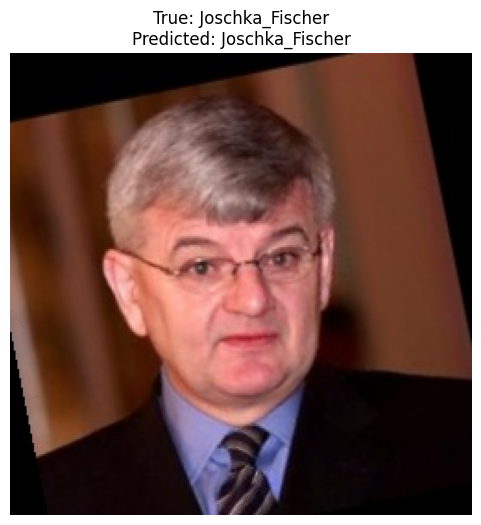

Top 5 predictions:
1. Joschka_Fischer: 0.9618
2. Richard_Gere: 0.0065
3. Mahmoud_Abbas: 0.0029
4. John_Bolton: 0.0022
5. Bill_Gates: 0.0017


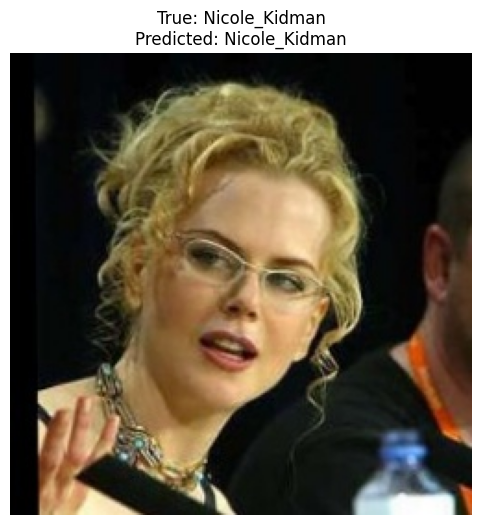

Top 5 predictions:
1. Nicole_Kidman: 0.8967
2. Meryl_Streep: 0.0062
3. Hillary_Clinton: 0.0058
4. Naomi_Watts: 0.0033
5. Angelina_Jolie: 0.0030


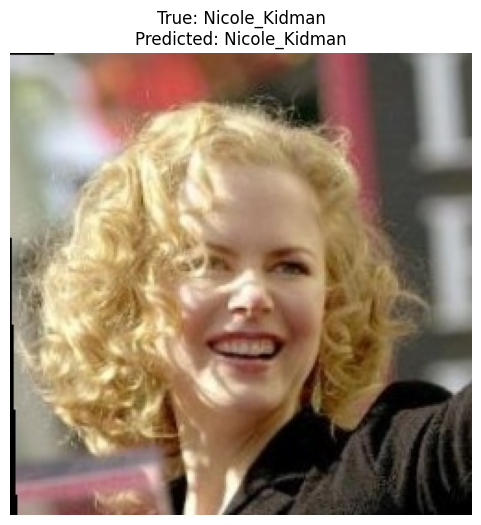

Top 5 predictions:
1. Nicole_Kidman: 0.8047
2. Naomi_Watts: 0.0315
3. Meryl_Streep: 0.0120
4. Britney_Spears: 0.0098
5. Kim_Clijsters: 0.0084
Training and evaluation complete! The model has been saved as 'best_vit_lfw_model.pth'


In [16]:
# Function to make prediction on a single image
def predict_image(model, image_path, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()
    predicted_person = label_to_person[predicted_label]

    return predicted_person, output.squeeze(0)

# Test on a random image
def test_random_image():
    # Select a random test image
    random_idx = np.random.randint(len(test_df))
    test_image_path = test_df.iloc[random_idx]['image_path']
    true_label = test_df.iloc[random_idx]['label']
    true_person = test_df.iloc[random_idx]['person']

    # Make prediction
    predicted_person, output = predict_image(model, test_image_path, test_transform)

    # Display the image and prediction
    image = Image.open(test_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'True: {true_person}\nPredicted: {predicted_person}')
    plt.axis('off')
    plt.show()

    # Display top 5 predictions
    probs = torch.softmax(output, dim=0)
    top_probs, top_indices = torch.topk(probs, 5)

    print("Top 5 predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs.cpu().numpy(), top_indices.cpu().numpy())):
        print(f"{i+1}. {label_to_person[idx]}: {prob:.4f}")

# Test on a few random images
for _ in range(3):
    test_random_image()

print("Training and evaluation complete! The model has been saved as 'best_vit_lfw_model.pth'")